<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & NLP

## Part 2: Modeling & Evaluation

In [115]:
# Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, plot_roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC

In [116]:
hbo_netflix = pd.read_csv('../data/hbo_netflix.csv')
cvec2 = pd.read_csv('../data/cvec2.csv')
cvec_bigrams2 = pd.read_csv('../data/cvec_bigrams2.csv')
cvec_tfidf2 = pd.read_csv('../data/cvec_tfidf2.csv')

In [117]:
# Defining X variables for each Count Vectorizer method

X_cvec = cvec2.iloc[:, 1:]
X_cvec_bigrams = cvec_bigrams2.iloc[:, 1:]
X_tfidf = cvec_tfidf2.iloc[:, 1:]
y = hbo_netflix['subreddit']

### Naive Bayes - Multinomial

I will focus on using the Multinomial Naive Bayes model out of the 3 Naive Bayes models available as it is commonly used for text classification problems and is well-suited for discrete data like word counts. Additionally, it works well even with correlated features and has a fast training speed and low memory requirements, making it an efficient choice for large datasets.

#### Count Vectorizer

In [118]:
X_train_cvec, X_test_cvec, y_train_cvec, y_test_cvec = train_test_split(X_cvec, y, random_state=42, stratify= y)
y_test_cvec.value_counts(normalize=True)

1    0.502041
0    0.497959
Name: subreddit, dtype: float64

In [119]:
cvec_nb = MultinomialNB()
cvec_nb.fit(X_train_cvec, y_train_cvec)

cvec_nb_train_score = cvec_nb.score(X_train_cvec, y_train_cvec)
cvec_nb_test_score = cvec_nb.score(X_test_cvec, y_test_cvec)

print(f'Train Score: {cvec_nb_train_score.round(3)}')
print(f'Test Score: {cvec_nb_test_score.round(3)}')

Train Score: 0.948
Test Score: 0.784


In [120]:
y_pred_cvec = cvec_nb.predict(X_test_cvec)

accuracy_cvec = accuracy_score(y_test_cvec, y_pred_cvec)
recall_cvec = recall_score(y_test_cvec, y_pred_cvec)
precision_cvec = precision_score(y_test_cvec, y_pred_cvec)
f1_cvec = f1_score(y_test_cvec, y_pred_cvec)

print(f'Prediction Accuracy: {accuracy_cvec.round(3)}\nPrediction Recall: {recall_cvec.round(3)}\nPrediction Precision: {precision_cvec.round(3)}\nPrediction F1: {f1_cvec.round(3)}')

Prediction Accuracy: 0.784
Prediction Recall: 0.789
Prediction Precision: 0.782
Prediction F1: 0.785


In [121]:
def plot_cm_roc(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    annot_labels = []
    for index,value in enumerate(cm):
        if index == 0:
            annot_labels.append(['TN = ' + str(value[0]), 'FP = ' + str(value[1])])
        if index == 1:
            annot_labels.append(['FN = ' + str(value[0]), 'TP = ' + str(value[1])])
    
    accuracy = round((cm[0][0]+cm[1][1])/sum(sum(cm)),3)
    precision = round(cm[1][1]/(cm[0][1]+cm[1][1]),3)
    recall = round(cm[1][1]/(cm[1][0]+cm[1][1]),3)
    f1 = round(2*(precision*recall)/(precision+recall),3)

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plt.subplots_adjust(wspace=0.4)

    sns.heatmap(cm, annot=np.array(annot_labels),
                fmt="",
                annot_kws={"size": 14},
                linewidths=.5,
                square = True,
                cmap = 'Greens',
                xticklabels = ['HBO', 'Netflix'],
                yticklabels = ['HBO', 'Netflix'],
                ax=axes[0])
    axes[0].set_ylabel('Actual', fontsize = 14);
    axes[0].set_xlabel('Predicted', fontsize = 14);
    axes[0].set_title('Confusion Matrix', size = 16);

    plot_roc_curve(model, X_test, y_test, ax=axes[1])
    axes[1].plot([0, 1], [0, 1], label='baseline', linestyle='--')
    axes[1].legend();
    axes[1].set_title('ROC Curve', size = 16)

    plt.suptitle(title+'\n'
                  +'Accuracy: {:.3f}'.format(accuracy)+'\n'
                  +'Precision: {:.3f}'.format(precision)+'\n'
                  +'Recall: {:.3f}'.format(recall)+'\n'
                  +'F1: {:.3f}'.format(f1)+'\n', size = 11);

    plt.show()

/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


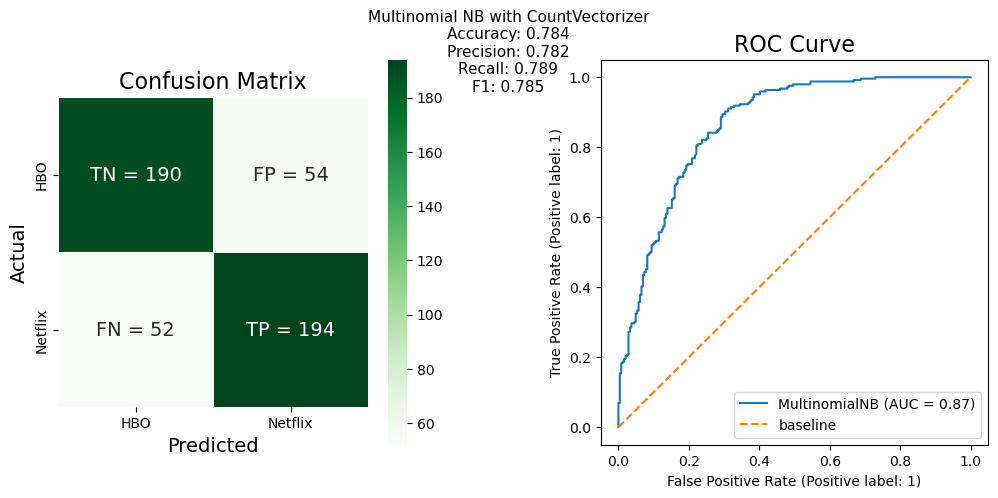

In [122]:
plot_cm_roc(cvec_nb, X_test_cvec, y_test_cvec, 'Multinomial NB with CountVectorizer')

#### Count Vectorizer with n-grams

In [123]:
X_train_cvec_bigrams, X_test_cvec_bigrams, y_train_cvec_bigrams, y_test_cvec_bigrams = \
train_test_split(X_cvec_bigrams, y, random_state=42, stratify= y)

In [124]:
cvec_bigrams_nb = MultinomialNB()
cvec_bigrams_nb.fit(X_train_cvec_bigrams, y_train_cvec_bigrams)

cvec_bigrams_nb_train_score = cvec_bigrams_nb.score(X_train_cvec_bigrams, y_train_cvec_bigrams)
cvec_bigrams_nb_test_score = cvec_bigrams_nb.score(X_test_cvec_bigrams, y_test_cvec_bigrams)

print(f'Train Score: {cvec_bigrams_nb_train_score.round(3)}')
print(f'Test Score: {cvec_bigrams_nb_test_score.round(3)}')

Train Score: 0.989
Test Score: 0.622


In [125]:
y_pred_cvec_bigrams = cvec_bigrams_nb.predict(X_test_cvec_bigrams)

accuracy_cvec_bigrams = accuracy_score(y_test_cvec_bigrams, y_pred_cvec_bigrams)
recall_cvec_bigrams = recall_score(y_test_cvec_bigrams, y_pred_cvec_bigrams)
precision_cvec_bigrams = precision_score(y_test_cvec_bigrams, y_pred_cvec_bigrams)
f1_cvec_bigrams = f1_score(y_test_cvec_bigrams, y_pred_cvec_bigrams)

print(f'Prediction Accuracy: {accuracy_cvec_bigrams.round(3)}\nPrediction Recall: {recall_cvec_bigrams.round(3)}\nPrediction Precision: {precision_cvec_bigrams.round(3)}\nPrediction F1: {f1_cvec_bigrams.round(3)}')

Prediction Accuracy: 0.622
Prediction Recall: 0.317
Prediction Precision: 0.821
Prediction F1: 0.457


/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


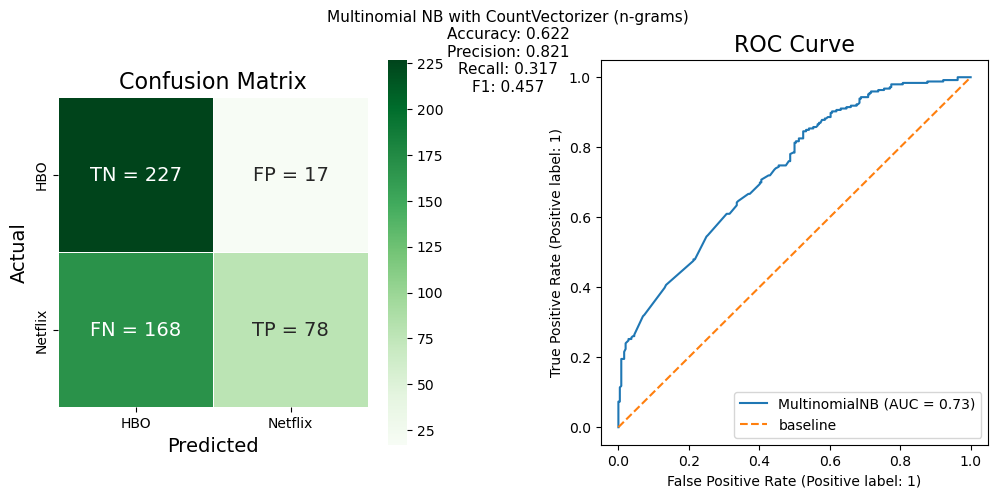

In [126]:
plot_cm_roc(cvec_bigrams_nb, X_test_cvec_bigrams, y_test_cvec_bigrams, 'Multinomial NB with CountVectorizer (n-grams)')

#### TF-IDF Vectorizer

In [127]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, random_state=42, stratify= y)

In [128]:
tfidf_nb = MultinomialNB()
tfidf_nb.fit(X_train_tfidf, y_train_tfidf)

tfidf_nb_train_score = tfidf_nb.score(X_train_tfidf, y_train_tfidf)
tfidf_nb_test_score = tfidf_nb.score(X_test_tfidf, y_test_tfidf)

print(f'Train Score: {tfidf_nb_train_score.round(3)}')
print(f'Test Score: {tfidf_nb_test_score.round(3)}')

Train Score: 0.957
Test Score: 0.802


In [129]:
y_pred_tfidf = tfidf_nb.predict(X_test_tfidf)

accuracy_tfidf = accuracy_score(y_test_tfidf, y_pred_tfidf)
recall_tfidf = recall_score(y_test_tfidf, y_pred_tfidf)
precision_tfidf = precision_score(y_test_tfidf, y_pred_tfidf)
f1_tfidf = f1_score(y_test_tfidf, y_pred_tfidf)

print(f'Prediction Accuracy: {accuracy_tfidf.round(3)}\nPrediction Recall: {recall_tfidf.round(3)}\nPrediction Precision: {precision_tfidf.round(3)}\nPrediction F1: {f1_tfidf.round(3)}')

Prediction Accuracy: 0.802
Prediction Recall: 0.833
Prediction Precision: 0.785
Prediction F1: 0.809


/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


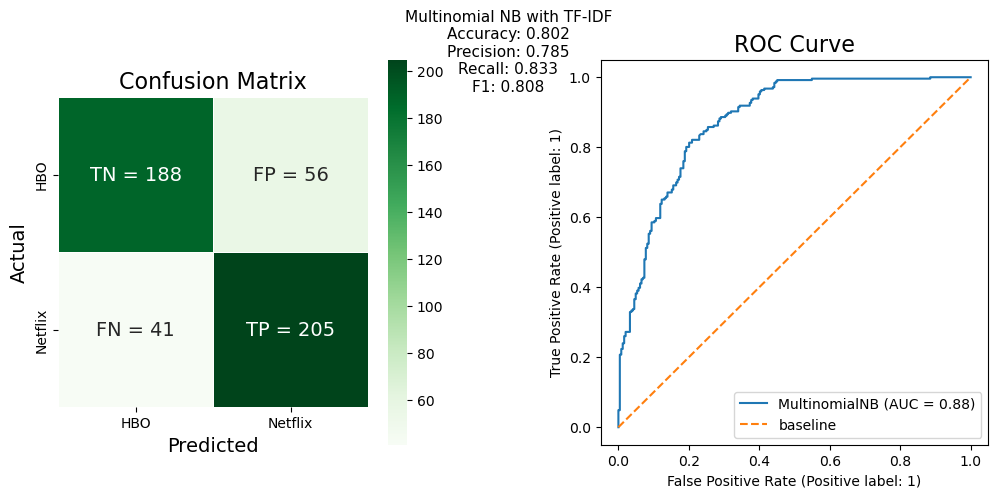

In [130]:
plot_cm_roc(tfidf_nb, X_test_tfidf, y_test_tfidf, 'Multinomial NB with TF-IDF')

### Logistic Regression

#### Count Vectorizer

In [131]:
X_train_cvec_lr, X_test_cvec_lr, y_train_cvec_lr, y_test_cvec_lr = \
train_test_split(X_cvec, y, random_state=42, stratify= y)

In [132]:
cvec_lr = LogisticRegression(solver= 'liblinear', max_iter = 500, n_jobs= -1)
cvec_lr.fit(X_train_cvec_lr, y_train_cvec_lr)

cvec_lr_train_score = cvec_lr.score(X_train_cvec_lr, y_train_cvec_lr)
cvec_lr_test_score = cvec_lr.score(X_test_cvec_lr, y_test_cvec_lr)

print(f'Train Score: {cvec_lr_train_score.round(3)}')
print(f'Test Score: {cvec_lr_test_score.round(3)}')

/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Train Score: 0.993
Test Score: 0.776


In [133]:
y_pred_cvec_lr = cvec_lr.predict(X_test_cvec_lr)

accuracy_cvec_lr = accuracy_score(y_test_cvec_lr, y_pred_cvec_lr)
recall_cvec_lr = recall_score(y_test_cvec_lr, y_pred_cvec_lr)
precision_cvec_lr = precision_score(y_test_cvec_lr, y_pred_cvec_lr)
f1_cvec_lr = f1_score(y_test_cvec_lr, y_pred_cvec_lr)

print(f'Prediction Accuracy: {accuracy_cvec_lr.round(3)}\nPrediction Recall: {recall_cvec_lr.round(3)}\nPrediction Precision: {precision_cvec_lr.round(3)}\nPrediction F1: {f1_cvec_lr.round(3)}')

Prediction Accuracy: 0.776
Prediction Recall: 0.829
Prediction Precision: 0.75
Prediction F1: 0.788


/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


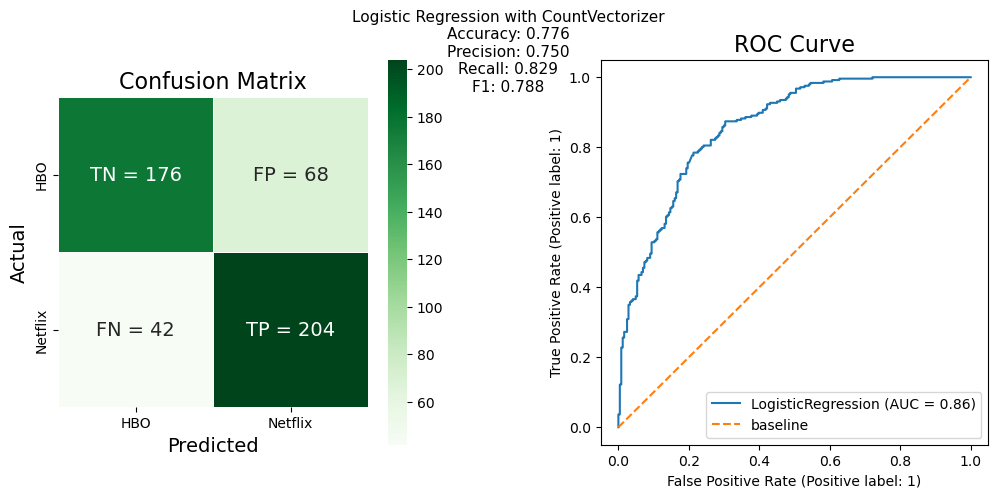

In [134]:
plot_cm_roc(cvec_lr, X_test_cvec_lr, y_test_cvec_lr, 'Logistic Regression with CountVectorizer')

In [135]:
# Check out coefficients
pd.Series(cvec_lr.coef_[0], index = X_test_cvec_lr.columns).sort_values()

us               -2.799581
max              -2.792959
euphoria         -1.808802
succession       -1.766183
white            -1.728059
                    ...   
similar           0.928037
really            0.941817
stranger          1.025634
account           1.044416
recommendation    1.172229
Length: 6468, dtype: float64

The above implies that for a 1 unit increase in 'us', the log-odds of the predicted probability of HBO (0) increases by 2.8 units. Conversely, for a 1 unit increase in 'recommendation', the log-odds of the predicted probability of Netflix (1) increases by 1.17 units.

#### Count Vectorizer with n-grams

In [136]:
X_train_cvec_bigrams_lr, X_test_cvec_bigrams_lr, y_train_cvec_bigrams_lr, y_test_cvec_bigrams_lr = \
train_test_split(X_cvec_bigrams, y, random_state=42, stratify= y)

In [137]:
cvec_bigrams_lr = LogisticRegression(solver= 'liblinear', max_iter = 500, n_jobs= -1)
cvec_bigrams_lr.fit(X_train_cvec_bigrams_lr, y_train_cvec_bigrams_lr)

cvec_bigrams_lr_train_score = cvec_bigrams_lr.score(X_train_cvec_bigrams_lr, y_train_cvec_bigrams_lr)
cvec_bigrams_lr_test_score = cvec_bigrams_lr.score(X_test_cvec_bigrams_lr, y_test_cvec_bigrams_lr)

print(f'Train Score: {cvec_bigrams_lr_train_score.round(3)}')
print(f'Test Score: {cvec_bigrams_lr_test_score.round(3)}')

/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


Train Score: 0.989
Test Score: 0.724


In [138]:
y_pred_cvec_bigrams_lr = cvec_bigrams_lr.predict(X_test_cvec_bigrams_lr)

accuracy_cvec_bigrams_lr = accuracy_score(y_test_cvec_bigrams_lr, y_pred_cvec_bigrams_lr)
recall_cvec_bigrams_lr = recall_score(y_test_cvec_bigrams_lr, y_pred_cvec_bigrams_lr)
precision_cvec_bigrams_lr = precision_score(y_test_cvec_bigrams_lr, y_pred_cvec_bigrams_lr)
f1_cvec_bigrams_lr = f1_score(y_test_cvec_bigrams_lr, y_pred_cvec_bigrams_lr)

print(f'Prediction Accuracy: {accuracy_cvec_bigrams_lr.round(3)}\nPrediction Recall: {recall_cvec_bigrams_lr.round(3)}\nPrediction Precision: {precision_cvec_bigrams_lr.round(3)}\nPrediction F1: {f1_cvec_bigrams_lr.round(3)}')

Prediction Accuracy: 0.724
Prediction Recall: 0.963
Prediction Precision: 0.653
Prediction F1: 0.778


/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


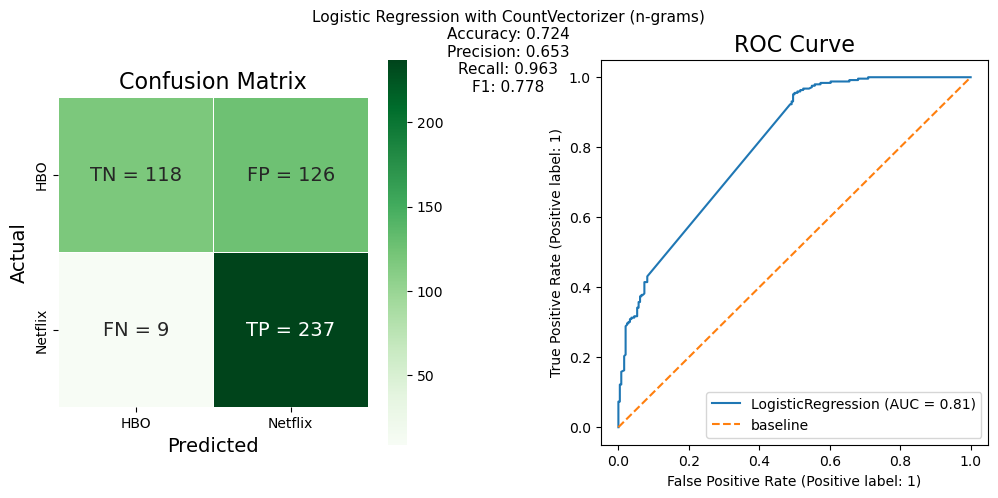

In [139]:
plot_cm_roc(cvec_bigrams_lr, X_test_cvec_bigrams_lr, y_test_cvec_bigrams_lr, 'Logistic Regression with CountVectorizer (n-grams)')

In [140]:
# Check out coefficients
pd.Series(cvec_bigrams_lr.coef_[0], index = X_test_cvec_bigrams_lr.columns).sort_values()

last us            -3.296019
white lotus        -1.815597
house dragon       -1.561633
game throne        -1.498416
air saturday       -1.478979
                      ...   
releasing march     0.723318
outer bank          0.780726
red rose            0.942148
password sharing    1.085709
chris rock          1.499413
Length: 20009, dtype: float64

#### TF-IDF Vectorizer

In [141]:
X_train_tfidf_lr, X_test_tfidf_lr, y_train_tfidf_lr, y_test_tfidf_lr = train_test_split(X_tfidf, y, random_state=42, stratify= y)

In [142]:
tfidf_lr = LogisticRegression(solver= 'liblinear', max_iter = 500, n_jobs= -1)
tfidf_lr.fit(X_train_tfidf_lr, y_train_tfidf_lr)

tfidf_lr_train_score = tfidf_lr.score(X_train_tfidf_lr, y_train_tfidf_lr)
tfidf_lr_test_score = tfidf_lr.score(X_test_tfidf_lr, y_test_tfidf_lr)

print(f'Train Score: {tfidf_lr_train_score.round(3)}')
print(f'Test Score: {tfidf_lr_test_score.round(3)}')

Train Score: 0.964
Test Score: 0.78


/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1523: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  warnings.warn(


In [143]:
y_pred_tfidf_lr = tfidf_lr.predict(X_test_tfidf_lr)

accuracy_tfidf_lr = accuracy_score(y_test_tfidf_lr, y_pred_tfidf_lr)
recall_tfidf_lr = recall_score(y_test_tfidf_lr, y_pred_tfidf_lr)
precision_tfidf_lr = precision_score(y_test_tfidf_lr, y_pred_tfidf_lr)
f1_tfidf_lr = f1_score(y_test_tfidf_lr, y_pred_tfidf_lr)

print(f'Prediction Accuracy: {accuracy_tfidf_lr.round(3)}\nPrediction Recall: {recall_tfidf_lr.round(3)}\nPrediction Precision: {precision_tfidf_lr.round(3)}\nPrediction F1: {f1_tfidf_lr.round(3)}')

Prediction Accuracy: 0.78
Prediction Recall: 0.89
Prediction Precision: 0.73
Prediction F1: 0.802


/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


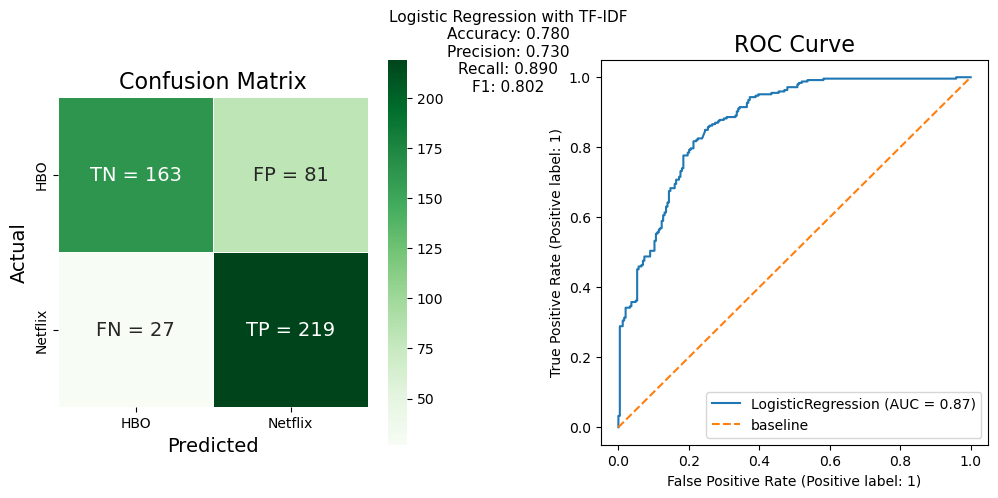

In [144]:
plot_cm_roc(tfidf_lr, X_test_tfidf_lr, y_test_tfidf_lr, 'Logistic Regression with TF-IDF')

In [145]:
# Check out coefficients
pd.Series(tfidf_lr.coef_[0], index = X_test_tfidf_lr.columns).sort_values()

max              -3.681696
us               -3.678861
last             -2.473476
euphoria         -2.141593
wire             -2.104743
                    ...   
list              1.077205
chris             1.171150
recommendation    1.251130
rock              1.267931
account           1.895720
Length: 6468, dtype: float64

### Random Forest

#### Count Vectorizer

In [146]:
X_train_cvec_rf, X_test_cvec_rf, y_train_cvec_rf, y_test_cvec_rf = \
train_test_split(X_cvec, y, random_state=42, stratify= y)

In [147]:
cvec_rf = RandomForestClassifier(n_jobs= -1)
cvec_rf.fit(X_train_cvec_rf, y_train_cvec_rf)

cvec_rf_train_score = cvec_rf.score(X_train_cvec_rf, y_train_cvec_rf)
cvec_rf_test_score = cvec_rf.score(X_test_cvec_rf, y_test_cvec_rf)

print(f'Train Score: {cvec_rf_train_score.round(3)}')
print(f'Test Score: {cvec_rf_test_score.round(3)}')

Train Score: 0.999
Test Score: 0.757


In [148]:
y_pred_cvec_rf = cvec_rf.predict(X_test_cvec_rf)

accuracy_cvec_rf = accuracy_score(y_test_cvec_rf, y_pred_cvec_rf)
recall_cvec_rf = recall_score(y_test_cvec_rf, y_pred_cvec_rf)
precision_cvec_rf = precision_score(y_test_cvec_rf, y_pred_cvec_rf)
f1_cvec_rf = f1_score(y_test_cvec_rf, y_pred_cvec_rf)

print(f'Prediction Accuracy: {accuracy_cvec_rf.round(3)}\nPrediction Recall: {recall_cvec_rf.round(3)}\nPrediction Precision: {precision_cvec_rf.round(3)}\nPrediction F1: {f1_cvec_rf.round(3)}')

Prediction Accuracy: 0.757
Prediction Recall: 0.931
Prediction Precision: 0.692
Prediction F1: 0.794


/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


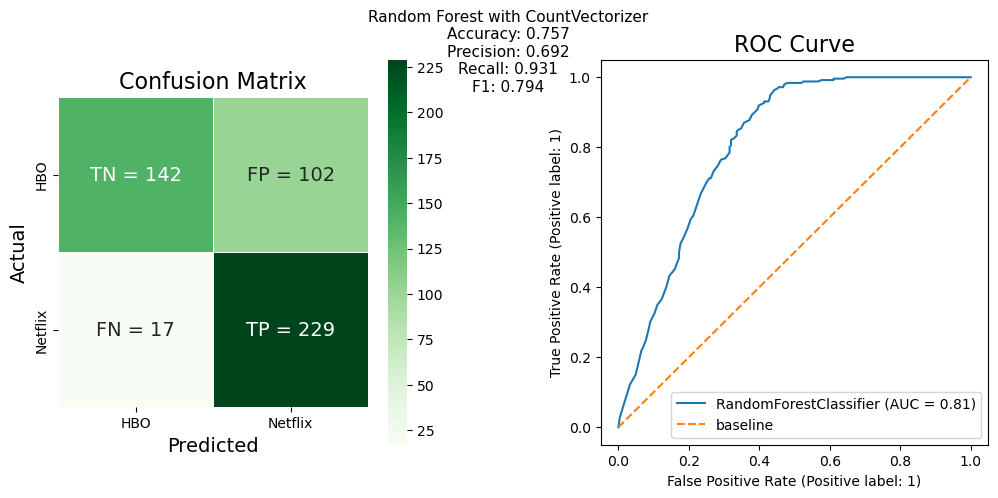

In [149]:
plot_cm_roc(cvec_rf, X_test_cvec_rf, y_test_cvec_rf, 'Random Forest with CountVectorizer')

#### Count Vectorizer with n-grams

In [150]:
X_train_cvec_bigrams_rf, X_test_cvec_bigrams_rf, y_train_cvec_bigrams_rf, y_test_cvec_bigrams_rf = \
train_test_split(X_cvec_bigrams, y, random_state=42, stratify= y)

In [151]:
cvec_bigrams_rf = RandomForestClassifier(n_jobs= -1)
cvec_bigrams_rf.fit(X_train_cvec_bigrams_rf, y_train_cvec_bigrams_rf)

cvec_bigrams_rf_train_score = cvec_bigrams_rf.score(X_train_cvec_bigrams_rf, y_train_cvec_bigrams_rf)
cvec_bigrams_rf_test_score = cvec_bigrams_rf.score(X_test_cvec_bigrams_rf, y_test_cvec_bigrams_rf)

print(f'Train Score: {cvec_bigrams_rf_train_score.round(3)}')
print(f'Test Score: {cvec_bigrams_rf_test_score.round(3)}')

Train Score: 0.989
Test Score: 0.7


In [152]:
y_pred_cvec_bigrams_rf = cvec_bigrams_rf.predict(X_test_cvec_bigrams_rf)

accuracy_cvec_bigrams_rf = accuracy_score(y_test_cvec_bigrams_rf, y_pred_cvec_bigrams_rf)
recall_cvec_bigrams_rf = recall_score(y_test_cvec_bigrams_rf, y_pred_cvec_bigrams_rf)
precision_cvec_bigrams_rf = precision_score(y_test_cvec_bigrams_rf, y_pred_cvec_bigrams_rf)
f1_cvec_bigrams_rf = f1_score(y_test_cvec_bigrams_rf, y_pred_cvec_bigrams_rf)

print(f'Prediction Accuracy: {accuracy_cvec_bigrams_rf.round(3)}\nPrediction Recall: {recall_cvec_bigrams_rf.round(3)}\nPrediction Precision: {precision_cvec_bigrams_rf.round(3)}\nPrediction F1: {f1_cvec_bigrams_rf.round(3)}')

Prediction Accuracy: 0.7
Prediction Recall: 0.988
Prediction Precision: 0.628
Prediction F1: 0.768


/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


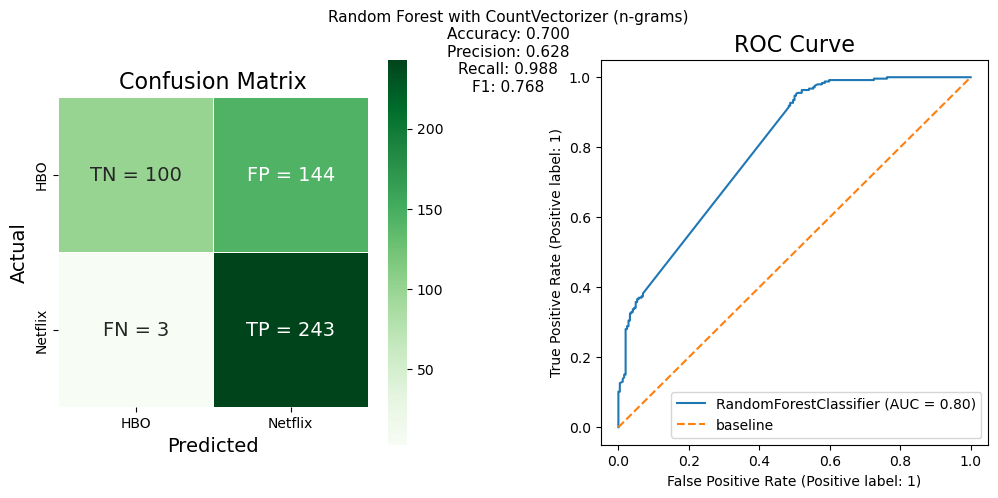

In [153]:
plot_cm_roc(cvec_bigrams_rf, X_test_cvec_bigrams_rf, y_test_cvec_bigrams_rf, 'Random Forest with CountVectorizer (n-grams)')

#### TF-IDF Vectorizer

In [154]:
X_train_tfidf_rf, X_test_tfidf_rf, y_train_tfidf_rf, y_test_tfidf_rf = \
train_test_split(X_tfidf, y, random_state=42, stratify= y)

In [155]:
tfidf_rf = RandomForestClassifier(n_jobs=-1)
tfidf_rf.fit(X_train_tfidf_rf, y_train_tfidf_rf)

tfidf_rf_train_score = tfidf_rf.score(X_train_tfidf_rf, y_train_tfidf_rf)
tfidf_rf_test_score = tfidf_rf.score(X_test_tfidf_rf, y_test_tfidf_rf)

print(f'Train Score: {tfidf_rf_train_score.round(3)}')
print(f'Test Score: {tfidf_rf_test_score.round(3)}')

Train Score: 0.999
Test Score: 0.769


In [156]:
y_pred_tfidf_rf = tfidf_rf.predict(X_test_tfidf_rf)

accuracy_tfidf_rf = accuracy_score(y_test_tfidf_rf, y_pred_tfidf_rf)
recall_tfidf_rf = recall_score(y_test_tfidf_rf, y_pred_tfidf_rf)
precision_tfidf_rf = precision_score(y_test_tfidf_rf, y_pred_tfidf_rf)
f1_tfidf_rf = f1_score(y_test_tfidf_rf, y_pred_tfidf_rf)

print(f'Prediction Accuracy: {accuracy_tfidf_rf.round(3)}\nPrediction Recall: {recall_tfidf_rf.round(3)}\nPrediction Precision: {precision_tfidf_rf.round(3)}\nPrediction F1: {f1_tfidf_rf.round(3)}')

Prediction Accuracy: 0.769
Prediction Recall: 0.959
Prediction Precision: 0.696
Prediction F1: 0.807


/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


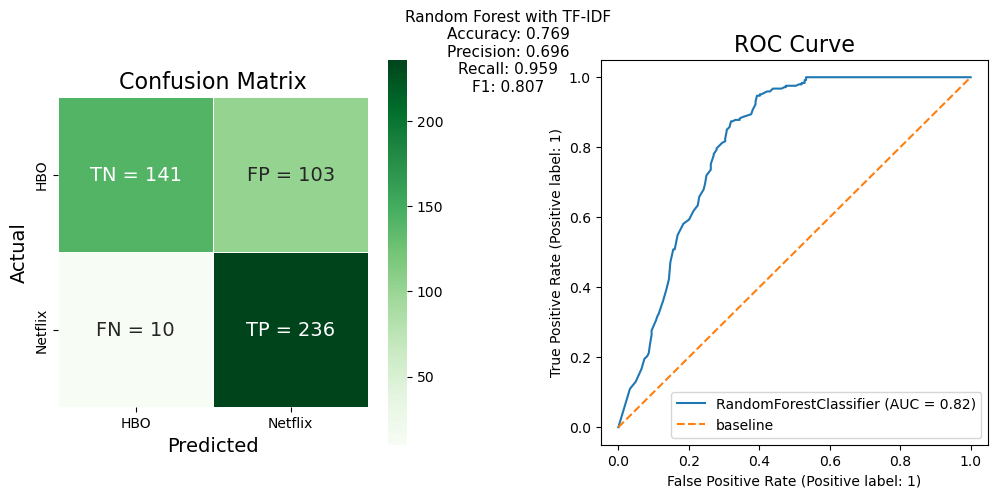

In [157]:
plot_cm_roc(tfidf_rf, X_test_tfidf_rf, y_test_tfidf_rf, 'Random Forest with TF-IDF')

### Gradient Boosting

#### Count Vectorizer

In [158]:
X_train_cvec_gb, X_test_cvec_gb, y_train_cvec_gb, y_test_cvec_gb = \
train_test_split(X_cvec, y, random_state=42, stratify= y)

In [159]:
cvec_gb = GradientBoostingClassifier()
cvec_gb.fit(X_train_cvec_gb, y_train_cvec_gb)

cvec_gb_train_score = cvec_gb.score(X_train_cvec_gb, y_train_cvec_gb)
cvec_gb_test_score = cvec_gb.score(X_test_cvec_gb, y_test_cvec_gb)

print(f'Train Score: {cvec_gb_train_score.round(3)}')
print(f'Test Score: {cvec_gb_test_score.round(3)}')

Train Score: 0.815
Test Score: 0.751


In [160]:
y_pred_cvec_gb = cvec_gb.predict(X_test_cvec_gb)

accuracy_cvec_gb = accuracy_score(y_test_cvec_gb, y_pred_cvec_gb)
recall_cvec_gb = recall_score(y_test_cvec_gb, y_pred_cvec_gb)
precision_cvec_gb = precision_score(y_test_cvec_gb, y_pred_cvec_gb)
f1_cvec_gb = f1_score(y_test_cvec_gb, y_pred_cvec_gb)

print(f'Prediction Accuracy: {accuracy_cvec_gb.round(3)}\nPrediction Recall: {recall_cvec_gb.round(3)}\nPrediction Precision: {precision_cvec_gb.round(3)}\nPrediction F1: {f1_cvec_gb.round(3)}')

Prediction Accuracy: 0.751
Prediction Recall: 0.976
Prediction Precision: 0.674
Prediction F1: 0.797


/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


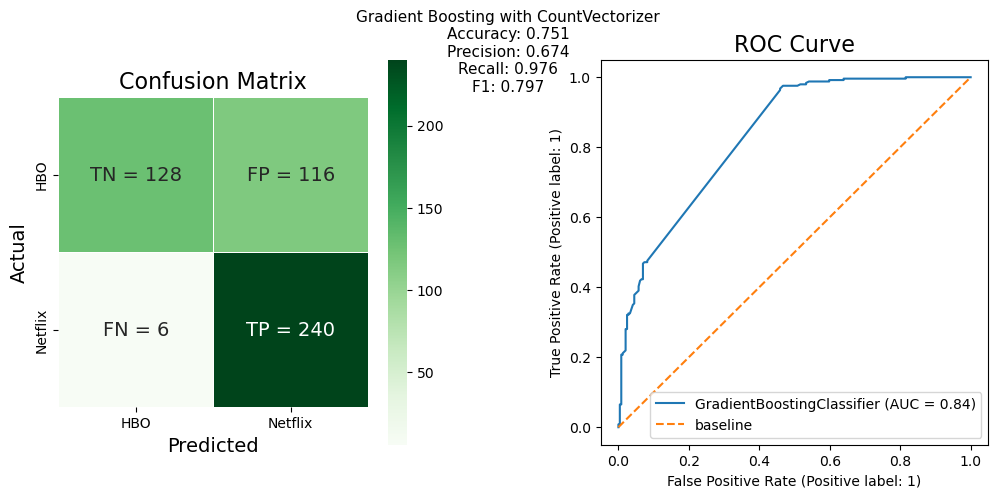

In [161]:
plot_cm_roc(cvec_gb, X_test_cvec_gb, y_test_cvec_gb, 'Gradient Boosting with CountVectorizer')

#### Count Vectorizer with n-grams

In [162]:
X_train_cvec_bigrams_gb, X_test_cvec_bigrams_gb, y_train_cvec_bigrams_gb, y_test_cvec_bigrams_gb = \
train_test_split(X_cvec_bigrams, y, random_state=42, stratify= y)

In [163]:
cvec_bigrams_gb = GradientBoostingClassifier()
cvec_bigrams_gb.fit(X_train_cvec_bigrams_gb, y_train_cvec_bigrams_gb)

cvec_bigrams_gb_train_score = cvec_bigrams_gb.score(X_train_cvec_bigrams_gb, y_train_cvec_bigrams_gb)
cvec_bigrams_gb_test_score = cvec_bigrams_gb.score(X_test_cvec_bigrams_gb, y_test_cvec_bigrams_gb)

print(f'Train Score: {cvec_bigrams_gb_train_score.round(3)}')
print(f'Test Score: {cvec_bigrams_gb_test_score.round(3)}')

Train Score: 0.702
Test Score: 0.661


In [164]:
y_pred_cvec_bigrams_gb = cvec_bigrams_gb.predict(X_test_cvec_bigrams_gb)

accuracy_cvec_bigrams_gb = accuracy_score(y_test_cvec_bigrams_gb, y_pred_cvec_bigrams_gb)
recall_cvec_bigrams_gb = recall_score(y_test_cvec_bigrams_gb, y_pred_cvec_bigrams_gb)
precision_cvec_bigrams_gb = precision_score(y_test_cvec_bigrams_gb, y_pred_cvec_bigrams_gb)
f1_cvec_bigrams_gb = f1_score(y_test_cvec_bigrams_gb, y_pred_cvec_bigrams_gb)

print(f'Prediction Accuracy: {accuracy_cvec_bigrams_gb.round(3)}\nPrediction Recall: {recall_cvec_bigrams_gb.round(3)}\nPrediction Precision: {precision_cvec_bigrams_gb.round(3)}\nPrediction F1: {f1_cvec_bigrams_gb.round(3)}')

Prediction Accuracy: 0.661
Prediction Recall: 0.992
Prediction Precision: 0.598
Prediction F1: 0.746


/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


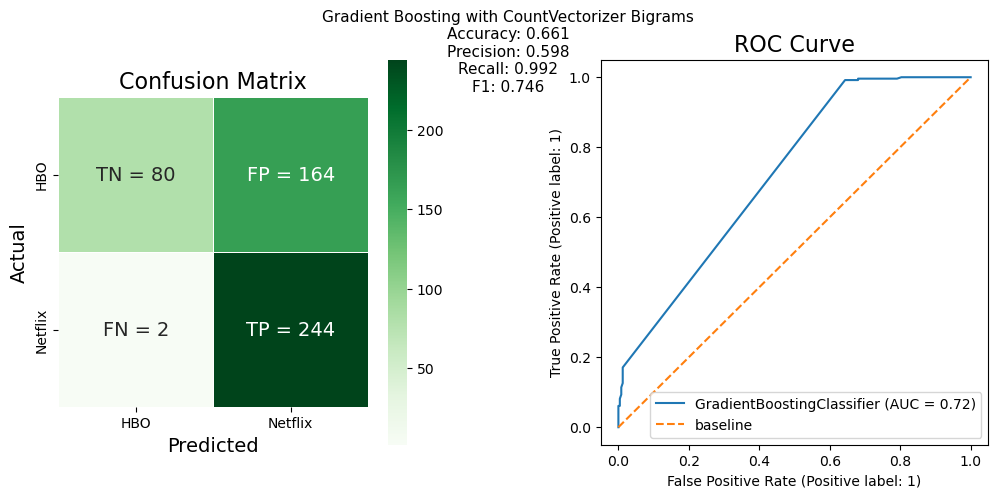

In [165]:
plot_cm_roc(cvec_bigrams_gb, X_test_cvec_bigrams_gb, y_test_cvec_bigrams_gb, 'Gradient Boosting with CountVectorizer Bigrams')

#### TF-IDF Vectorizer

In [166]:
X_train_tfidf_gb, X_test_tfidf_gb, y_train_tfidf_gb, y_test_tfidf_gb = \
train_test_split(X_tfidf, y, random_state=42, stratify= y)

In [167]:
tfidf_gb = GradientBoostingClassifier()
tfidf_gb.fit(X_train_tfidf_gb, y_train_tfidf_gb)

tfidf_gb_train_score = tfidf_gb.score(X_train_tfidf_gb, y_train_tfidf_gb)
tfidf_gb_test_score = tfidf_gb.score(X_test_tfidf_gb, y_test_tfidf_gb)

print(f'Train Score: {tfidf_gb_train_score.round(3)}')
print(f'Test Score: {tfidf_gb_test_score.round(3)}')

Train Score: 0.832
Test Score: 0.755


In [168]:
y_pred_tfidf_gb = tfidf_gb.predict(X_test_tfidf_gb)

accuracy_tfidf_gb = accuracy_score(y_test_tfidf_gb, y_pred_tfidf_gb)
recall_tfidf_gb = recall_score(y_test_tfidf_gb, y_pred_tfidf_gb)
precision_tfidf_gb = precision_score(y_test_tfidf_gb, y_pred_tfidf_gb)
f1_tfidf_gb = f1_score(y_test_tfidf_gb, y_pred_tfidf_gb)

print(f'Prediction Accuracy: {accuracy_tfidf_gb.round(3)}\nPrediction Recall: {recall_tfidf_gb.round(3)}\nPrediction Precision: {precision_tfidf_gb.round(3)}\nPrediction F1: {f1_tfidf_gb.round(3)}')

Prediction Accuracy: 0.755
Prediction Recall: 0.972
Prediction Precision: 0.679
Prediction F1: 0.799


### Linear SVC

#### Count Vectorizer

In [169]:
X_train_cvec_svc, X_test_cvec_svc, y_train_cvec_svc, y_test_cvec_svc = \
train_test_split(X_cvec, y, random_state=42, stratify= y)

In [170]:
cvec_svc = LinearSVC()
cvec_svc.fit(X_train_cvec_svc, y_train_cvec_svc)

cvec_svc_train_score = cvec_svc.score(X_train_cvec_svc, y_train_cvec_svc)
cvec_svc_test_score = cvec_svc.score(X_test_cvec_svc, y_test_cvec_svc)

print(f'Train Score: {cvec_svc_train_score.round(3)}')
print(f'Test Score: {cvec_svc_test_score.round(3)}')

Train Score: 0.999
Test Score: 0.751


In [171]:
y_pred_cvec_svc = cvec_svc.predict(X_test_cvec_svc)

accuracy_cvec_svc = accuracy_score(y_test_cvec_svc, y_pred_cvec_svc)
recall_cvec_svc = recall_score(y_test_cvec_svc, y_pred_cvec_svc)
precision_cvec_svc = precision_score(y_test_cvec_svc, y_pred_cvec_svc)
f1_cvec_svc = f1_score(y_test_cvec_svc, y_pred_cvec_svc)

print(f'Prediction Accuracy: {accuracy_cvec_svc.round(3)}\nPrediction Recall: {recall_cvec_svc.round(3)}\nPrediction Precision: {precision_cvec_svc.round(3)}\nPrediction F1: {f1_cvec_svc.round(3)}')

Prediction Accuracy: 0.751
Prediction Recall: 0.813
Prediction Precision: 0.725
Prediction F1: 0.766


/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


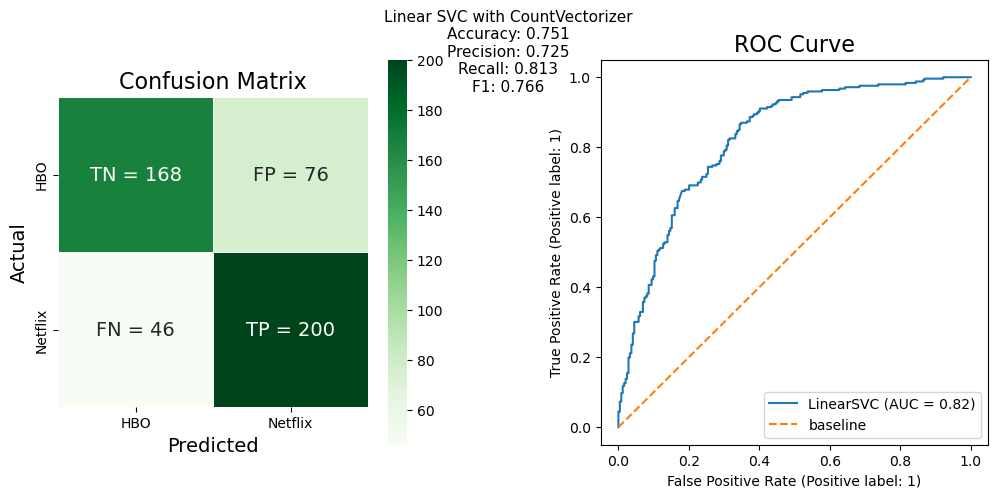

In [172]:
plot_cm_roc(cvec_svc, X_test_cvec_svc, y_test_cvec_svc, 'Linear SVC with CountVectorizer')

#### Count Vectorizer with n-grams

In [173]:
X_train_cvec_bigrams_svc, X_test_cvec_bigrams_svc, y_train_cvec_bigrams_svc, y_test_cvec_bigrams_svc = \
train_test_split(X_cvec_bigrams, y, random_state=42, stratify= y)

In [174]:
cvec_bigrams_svc = LinearSVC()
cvec_bigrams_svc.fit(X_train_cvec_bigrams_svc, y_train_cvec_bigrams_svc)

cvec_bigrams_svc_train_score = cvec_bigrams_svc.score(X_train_cvec_bigrams_svc, y_train_cvec_bigrams_svc)
cvec_bigrams_svc_test_score = cvec_bigrams_svc.score(X_test_cvec_bigrams_svc, y_test_cvec_bigrams_svc)

print(f'Train Score: {cvec_bigrams_svc_train_score.round(3)}')
print(f'Test Score: {cvec_bigrams_svc_test_score.round(3)}')

Train Score: 0.989
Test Score: 0.714


In [175]:
y_pred_cvec_bigrams_svc = cvec_bigrams_svc.predict(X_test_cvec_bigrams_svc)

accuracy_cvec_bigrams_svc = accuracy_score(y_test_cvec_bigrams_svc, y_pred_cvec_bigrams_svc)
recall_cvec_bigrams_svc = recall_score(y_test_cvec_bigrams_svc, y_pred_cvec_bigrams_svc)
precision_cvec_bigrams_svc = precision_score(y_test_cvec_bigrams_svc, y_pred_cvec_bigrams_svc)
f1_cvec_bigrams_svc = f1_score(y_test_cvec_bigrams_svc, y_pred_cvec_bigrams_svc)

print(f'Prediction Accuracy: {accuracy_cvec_bigrams_svc.round(3)}\nPrediction Recall: {recall_cvec_bigrams_svc.round(3)}\nPrediction Precision: {precision_cvec_bigrams_svc.round(3)}\nPrediction F1: {f1_cvec_bigrams_svc.round(3)}')

Prediction Accuracy: 0.714
Prediction Recall: 0.959
Prediction Precision: 0.645
Prediction F1: 0.771


/Users/Ron/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


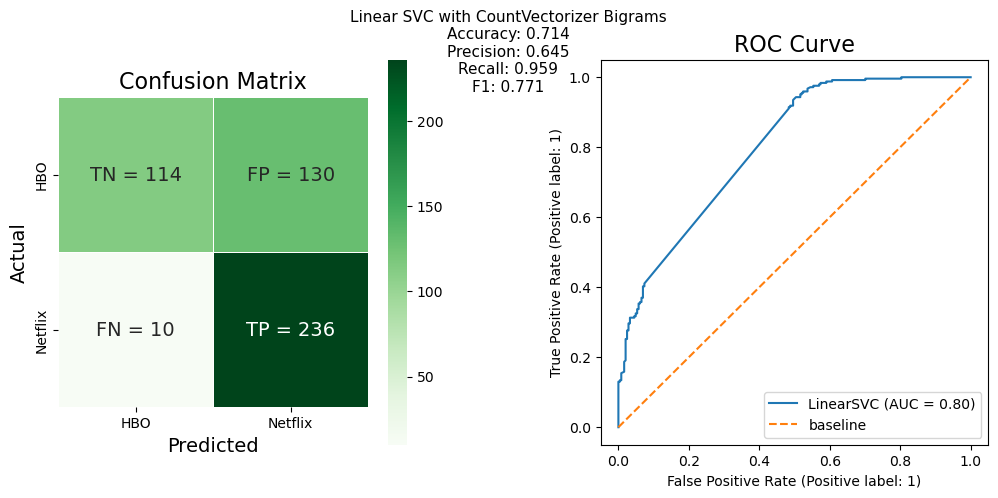

In [176]:
plot_cm_roc(cvec_bigrams_svc, X_test_cvec_bigrams_svc, y_test_cvec_bigrams_svc, 'Linear SVC with CountVectorizer Bigrams')

#### TF-IDF Vectorizer

In [177]:
X_train_tfidf_svc, X_test_tfidf_svc, y_train_tfidf_svc, y_test_tfidf_svc = \
train_test_split(X_tfidf, y, random_state=42, stratify= y)

In [178]:

tfidf_svc = LinearSVC()
tfidf_svc.fit(X_train_tfidf_svc, y_train_tfidf_svc)

tfidf_svc_train_score = tfidf_svc.score(X_train_tfidf_svc, y_train_tfidf_svc)
tfidf_svc_test_score = tfidf_svc.score(X_test_tfidf_svc, y_test_tfidf_svc)

print(f'Train Score: {tfidf_svc_train_score.round(3)}')
print(f'Test Score: {tfidf_svc_test_score.round(3)}')

Train Score: 0.998
Test Score: 0.78


In [179]:
y_pred_tfidf_svc = tfidf_svc.predict(X_test_tfidf_svc)

accuracy_tfidf_svc = accuracy_score(y_test_tfidf_svc, y_pred_tfidf_svc)
recall_tfidf_svc = recall_score(y_test_tfidf_svc, y_pred_tfidf_svc)
precision_tfidf_svc = precision_score(y_test_tfidf_svc, y_pred_tfidf_svc)
f1_tfidf_svc = f1_score(y_test_tfidf_svc, y_pred_tfidf_svc)

print(f'Prediction Accuracy: {accuracy_tfidf_svc.round(3)}\nPrediction Recall: {recall_tfidf_svc.round(3)}\nPrediction Precision: {precision_tfidf_svc.round(3)}\nPrediction F1: {f1_tfidf_svc.round(3)}')

Prediction Accuracy: 0.78
Prediction Recall: 0.833
Prediction Precision: 0.754
Prediction F1: 0.792


### Model results (in %)

|Model|Train Score|Test Score|
|---|---|---|
|Multinomial NB CV|94.8|78.4|
|Multinomial NB CV (n-grams|98.9|62.2|
|Multinomial TF-IDF|95.7|80.2|
|Logistic Regression CV|99.3|77.6|
|Logistic Regression CV (n-grams)|98.9|72.4|
|Logistic Regression TF-IDF|96.4|78.0|
|Random Forest CV|99.9|75.7|
|Random Forest CV (n-grams)|98.9|70.0|
|Random Forest TF-IDF|99.9|76.9|
|Gradient Boosting CV|81.5|75.1|
|Gradient Boosting CV (n-grams)|70.2|66.1|
|Gradient Boosting TF-IDF|83.2|75.5|
|Linear SVC CV|99.9|75.1|
|Linear SVC CV (n-grams)|98.9|71.4|
|Linear SVC TF-IDF|99.8|78.0|